# The Marine Navigation problem (Julia code)
### by P. Negre and M. Sadak ([Polytech Nice Sophia, Applied math. dep](http://www.polytech-nice-sophia.fr/formation/ingenieur-mathematiques-appliquees-et-modelisation))

We consider a ship moving in a portion of ocean undergoing a constant current (the whole fluid has constant horizontal velocity $w$) and towing a spread.
The towed streamer is made of $N$ segments of length $\ell$. After some normalisations, the system can be written as follows (see [this paper](http://caillau.perso.math.cnrs.fr/research/cdc-2019b.pdf) for a detailed description of the $N=1$ case):

$$
\left \lbrace
\begin{array}{l}
\dot x = w+\cos\theta,\\
\dot y = \sin\theta,\\
\dot\theta = u,\\
\dot\beta_k = -u-\frac 1l(\prod_{j=1}^{k-1}\cos(\beta_j -\beta_{j-1}))\sin(\beta_k - \beta_{k-1}),\\
\beta_k = \theta_k - \theta, \ \theta_0 = \theta,\\
|u| \le 1, \ 0\le w < 1, \ 0<l<1
\end{array}
\right.
$$

where $\alpha_k:=\theta_k-\theta_{k-1}$ (and $\theta_0:=\theta$). The minimum time problem is considered.

![Thumbnail](thumbnail.png)

[Thumbnail](thumbnail.png)

In [32]:
using JuMP, Plots, Ipopt

In [33]:
# Function to compute the roots for the u-turn
function theta(w,ϕ) 
    a = 1 + tan(ϕ)^2 
    b = 2*tan(ϕ)^2*w
    c = tan(ϕ)^2 * w^2 - 1 
    Δ = 4 * (tan(ϕ)^2(1-w^2)+1)

    t1 = (-b - sqrt(Δ))/(2*a)
    t2 = (-b + sqrt(Δ))/(2*a)
    
    θ1 = acos(t1)
    θ2 = acos(t2)
    return θ1,θ2
end

theta (generic function with 1 method)

In [34]:
# Specific parameters for each model 
P = 200 # number of points
N = 10  # number of trailers
M = N # M number of constrained trailers
is_u_turn = true
μ = 1e-4 # smoothing constant 

if N ≥ 2
    l = 1/ N # length of trailers  
else
    l = 1/sqrt(N)
end

# Initial data
x0 = 0 
y0 = 0 
c0 = 0

# Final data
xf = 4
yf = 7

if is_u_turn
    w = 0.4  
    ϕ0 = π/4
    is_current_constant = true
    θ0_1 = theta(w,ϕ0)[1]
    θ0_2 = - theta(w,ϕ0)[1]
    θ1_1 = theta(w,ϕ0)[2]
    θ1_2 = - theta(w,ϕ0)[2]
    θ0= angle(w + exp(im*θ1_1))
    θf = angle(w + exp(im*θ0_2))
else
    θ0 = π/7
    θf = 3*π/2
    is_current_constant = false 
end

-2.4488225543451825

In [35]:
#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"max_iter",1000)

JuMP.@variables(sys,begin
    x[1:P]                          # x 
    y[1:P]                          # y 
    θ[1:P]                       # theta 
    -1≤u[1:P]≤1
    0≤ Δt ≤ 1
    c[1:P]
    end) 

JuMP.@variable(sys, betas[1:P, 1:N])

# Objective
@objective(sys,Min,Δt+μ*c[P])

# Constraints
@constraints(sys,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    c[1] == c0

    x[P] == xf
    y[P] == yf
    θ[P] == θf
    end)

@constraint(sys,c1[j=1:N],
     betas[1,j]==0)

# Constraints for betas(tf)
if M != 0 
    @constraint(sys,c2[j=1:M],
     betas[P,j]==0) 
end

# Constraints for betas
((@constraint(sys, -sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i)  ≤betas[j,i]≤sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i)  ) for j in 1:P) for i in 1:N)

Base.Generator{UnitRange{Int64}, var"#89#91"}(var"#89#91"(), 1:10)

In [36]:
# Function wich gives the current velocity according to the x position (non-constant current)
ϵ = 0

function water(x,y) 
    if is_current_constant 
        wx = w
        wy = 0
    else
        η = @NLexpression(sys,ϵ + sqrt((w-ϵ*y)^2 + ϵ^2*x^2))
        wx = @NLexpression(sys,(w - ϵ*y)/ η)
        wy = @NLexpression(sys,ϵ*x / η)
    end
    return wx,wy
end

water (generic function with 1 method)

In [37]:
# Dynamics: Crank-Nicolson 
for j in 1 : P-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * ( water(x[j],y[j])[1] + cos(θ[j]) + water(x[j+1],y[j+1])[1]  + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *( water(x[j],y[j])[2] +sin(θ[j])+ sin(θ[j+1])+ water(x[j+1],y[j+1])[2]))
    
    if N ≥ 1  
       @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
            betas[j+1,1] == betas[j,1] + 0.5 * Δt * (-u[j]-(1/l)*sin(betas[j,1]) - u[j+1] - (1/l)*sin(betas[j+1,1]))) 
    end
    if N ≥ 2  
        @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
            betas[j+1,2] == betas[j,2] + 0.5 *  Δt * (-u[j] - cos(betas[j,1])*sin(betas[j,2] - betas[j,1])/l - u[j+1] - cos(betas[j+1,1])*sin(betas[j+1,2] - betas[j+1,1])/l ))   
    end
    if N ≥ 3 
        for i in 3 : N 
          prod1 = @NLexpression(sys,prod(cos(betas[j,p]-betas[j,p-1]) for p in 2 : i-1 )*sin(betas[j,i]-betas[j,i-1])*cos(betas[j,1]) )
          prod2 = @NLexpression(sys,prod(cos(betas[j+1,p]-betas[j+1,p-1]) for p in 2 : i-1 )*sin(betas[j+1,i]-betas[j+1,i-1])*cos(betas[j+1,1]) )  
          @NLconstraint(sys, #betas for i = 3 to N
                betas[j+1,i] == betas[j,i]+ 0.5*Δt*(-u[j]-prod1/l -u[j+1] -prod2/l ) ) 
        end
    end        
end
    
@NLconstraint(sys,p_t[j = 1:(P-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

@NLconstraint(sys, c_[j = 1:(P-1)],  # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))

#Solve for the control and state
println("Solving...")
status = optimize!(sys)
println("Solver status: ",status)
println("Cost: " , objective_value(sys))
println("tf = ", value.(Δt)*P)

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    31867
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   246561

Total number of variables............................:     3001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2813
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

In [38]:
# Plots: states 
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
betas1 = value.(betas)
u1 = value.(u)
Δt1 = value.(Δt)
t = (1 : P)*Δt1

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
u_plot = plot(t,u1,xlabel = "t", ylabel = "u", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,u_plot,layout = (4,1)))

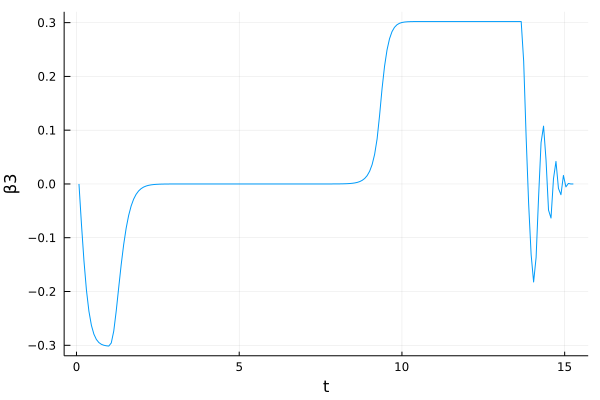

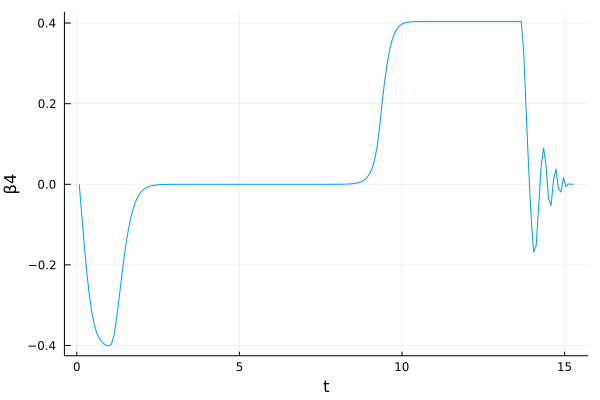

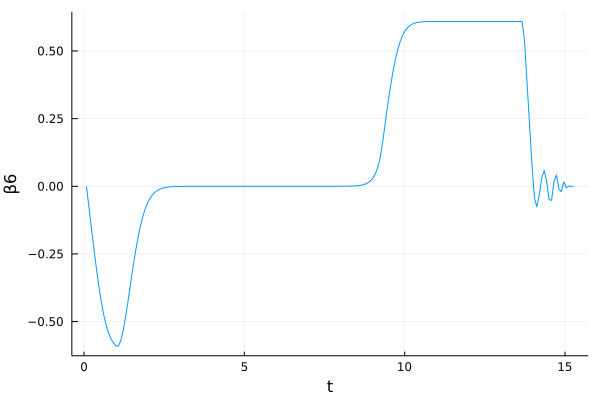

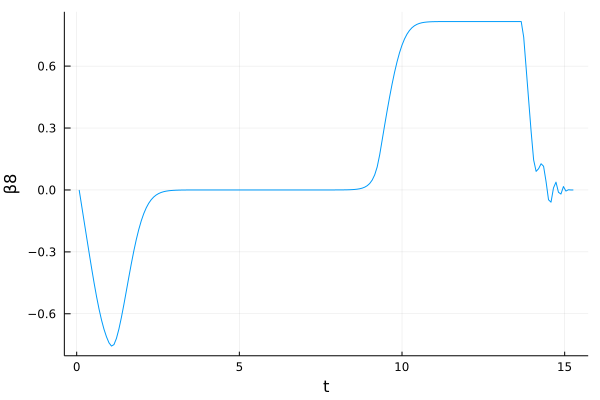

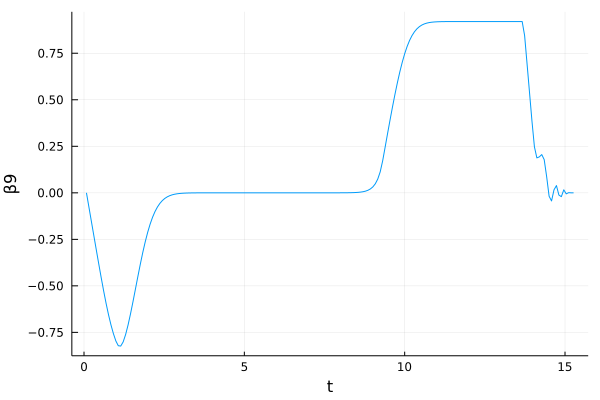

In [39]:
for i in 1:N # if N = 0 , there is no plot 
    name = "β" * string(i)
    display(plot(t,betas1[:,i],xlabel ="t",ylabel=name,legend =false,fmt = :png,layout =(1,1)))      
end

┌ Info: Saved animation to 
│   fn = /home/caillau/gallery/examples/nav/tmp.gif
└ @ Plots /home/caillau/.julia/packages/Plots/FKcum/src/animation.jl:104


Plots.AnimatedGif("/home/caillau/gallery/examples/nav/tmp.gif")
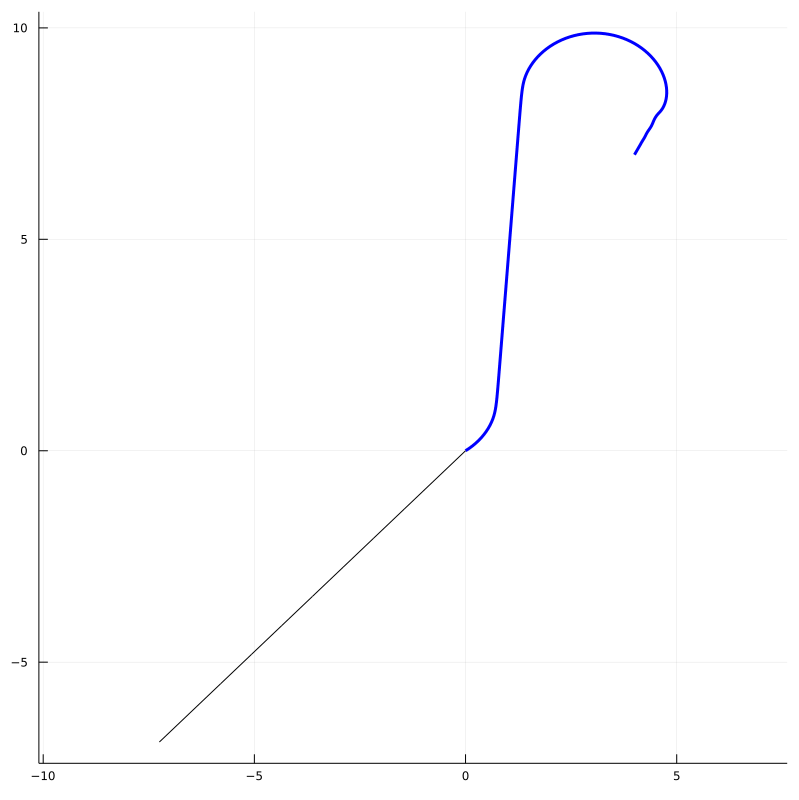

In [40]:
# Plots: trajectory 
p = plot(x1,y1,legend = false,c = :blue,lw = 3)
plot!(size=(500,500))

@gif for j = 1:2:P
    betas_z = zeros(2,N+1)       # storage of z_i = z_{i-1}-l*[cos(theta_{i-1}) sin(theta_{i-1})] 
    betas_z[1,1] = x1[j]
    betas_z[2,1] = y1[j]
    θ_p = θ1[j]
    β_v = zeros(N)
    θ_v = zeros(N)

    ll = 10*l # for better plot
    for i in 2:N+1
        
        β_v[i-1]= betas1[j,i-1]
        θ_v[i-1] = β_v[i-1] + θ_p
        betas_z[1,i] = betas_z[1,i-1] - ll*cos(θ_v[i-1])
        betas_z[2,i] = betas_z[2,i-1] - ll*sin(θ_v[i-1])
        plot!([betas_z[1,i-1], betas_z[1,i]],[betas_z[2,i-1], betas_z[2,i]], color = :black,legend = false )
        #plot!([betas_z[1,i-1]],[betas_z[2,i-1]],seriestype = :scatter,color = :black, lw = 2, legend = false)
        plot!(size=(800,800), aspect_ratio=:equal)
    end
end every 1

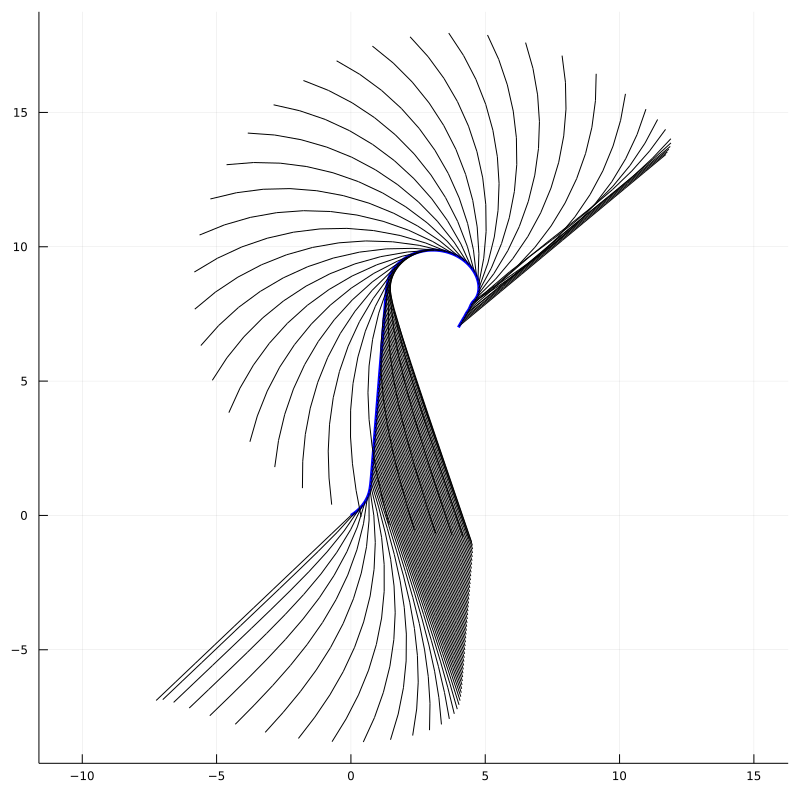

In [41]:
display(p)